In [14]:
import OffsetArrays
using Plots
using Revise
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using IterTools
using DelimitedFiles
include("../src/functions.jl")

avgAUC (generic function with 1 method)

# Population dynamics for the messages

In [15]:
Threads.nthreads()

40

In [16]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected
degreetype = "poisson"
d = 3 # degree 
T = 8 # discrete time
N = 15000; #population size
γ = 0.15
fr = 0.0
grid = 41

dilRange = LinRange(0.,0.5,2)
λRange = LinRange(0.01,0.4,grid) 
#folderstring = "./results/T=$(T)_d=$(d)_min=$(γvalues[1])_max=$(γvalues[end])_fr=$(fr)_dil=$(dil)/"

41-element LinRange{Float64, Int64}:
 0.01,0.01975,0.0295,0.03925,0.049,0.05875,…,0.361,0.37075,0.3805,0.39025,0.4

In [17]:



function inf_vs_dil(γ, λRange, N, T, dist, paramdist, fr , dilRange ; tot_iterations = 1 )
    inf_out = zeros(length(λRange),length(dilRange), T + 2) # 1 value for pdiag and T+1 values for the AUC
    Threads.@threads for (λcount,dilcount) in collect(product(1:length(λRange),1:length(dilRange)))
        λi = λp = λRange[λcount]
        γi = γp = γ
       # @show λi λp
        dilution = dilRange[dilcount]
        marg = pop_dynamics(N, T, λp, λi, γp, γi, dist, paramdist, tot_iterations = tot_iterations, fr=fr, dilution=dilution)
        marg2D = reshape((sum(marg,dims=1)./ N),T+2,T+2);
        # we sum over the trace of the 2D marginal to find the probability to infere correctly
        inf_out[λcount,dilcount,1] = sum([marg2D[t,t] for t=1:T+2])
        inf_out[λcount,dilcount,2:end] .= avgAUC(marg)
        #ProgressMeter.next!(pr)
    end
    return inf_out
end


inf_vs_dil (generic function with 1 method)

In [18]:
inf_out = inf_vs_dil(γ, λRange, N, T, degreetype, d, fr , dilRange , tot_iterations = 40);

In [19]:
open("./dil_lam_er_4/diag.txt","w") do io
    writedlm(io,inf_out[:,:,1]) 
end
for t = 1:T+1
    open("./dil_lam_er_4/AUC$(t).txt","w") do io
        writedlm(io,inf_out[:,:,t+1]) 
    end
end

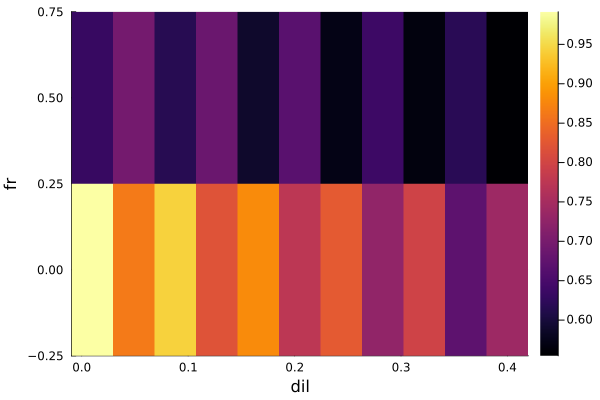

In [13]:
heatmap(λRange,dilRange,inf_out[:,:,2],ylabel="fr",xlabel="dil")